This notebook mirrors the steps taken in [this one (from 12 steps to navier stokes)](https://nbviewer.org/github/barbagroup/CFDPython/blob/master/lessons/14_Step_11.ipynb) almost exactly, but using convolutions instead of summing sliced matrices. 

In [431]:
import numpy
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.signal import convolve2d
%matplotlib inline

In [432]:
# wrapper for convolve 2d
def convolve(x,y): return convolve2d(x,y,mode='valid')

In [433]:
nx = 41
ny = 41
nt = 500
nit = 50
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = numpy.linspace(0, 2, nx)
y = numpy.linspace(0, 2, ny)
X, Y = numpy.meshgrid(x, y)

rho = 1
nu = .1
dt = .001

u = numpy.zeros((ny, nx))
v = numpy.zeros((ny, nx))
p = numpy.zeros((ny, nx)) 
b = numpy.zeros((ny, nx))

The pressure Poisson equation that's written above can be hard to write without typos. The function `build_up_b` below represents the contents of the square bracket, so that the entire of the PPE is slightly more managable. 

In [441]:
def build_up_b(b, rho, dt, u, v, dx, dy):
    ker_dx = np.array([[0,0,0],[1,0,-1],[0,0,0]]) / (2*dx)
    ker_dy = np.array([[0,1,0],[0,0,0],[0,-1,0]]) / (2*dy)
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    (convolve(u,ker_dx) + convolve(v,ker_dy)) -
                    np.square(convolve(u,ker_dx)) -
                    2 * (convolve(u,ker_dy) * convolve(v,ker_dx)) -
                    np.square(convolve(v,ker_dy))))
    return b

The function `pressure_poisson` is also defined to help segregate the different rounds of calculations. Note the pseudo-time variable `nit`. This sub-iteration in the Poisson calculation helps ensure a divergence-free field.

In [452]:
def pressure_poisson(p, dx, dy, b):
    pn = p.copy()
    
    for q in range(nit):
        pn = p.copy()
        ker_star = np.array([[0,dy*dy,0],[dx*dx,0,dx*dx],[0,dy*dy,0]])
        p[1:-1, 1:-1] = (convolve(pn,ker_star) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])

        # Enforce boundary conditions
        p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
        p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
        p[-1, :] = 0        # p = 0 at y = 2
        
    return p

Finally, the rest of the cavity flow equations are wrapped inside the function `cavity_flow`, allowing us to easily plot the results of the cavity flow solver for different lengths of time. 

In [444]:
def cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu):
    un = numpy.empty_like(u)
    vn = numpy.empty_like(v)
    b = numpy.zeros((ny, nx))
    
    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        
        b = build_up_b(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson(p, dx, dy, b)
        
        ker_xx = np.array([[0,0,0],[0,1,-1],[0,0,0]]) * dt / dx
        ker_yy = np.array([[0,0,0],[0,1,0],[0,-1,0]]) * dt / dy
        ker_cross = np.array([[0 ,          dt / dy**2 ,                    0],
                              [dt / dx**2 , -2*dt*(1 / dx**2 + 1 / dy**2) , dt / dx**2],
                              [0 ,          dt / dy**2 ,                    0]])
        ker_dx = np.array([[0,0,0],[1,0,-1],[0,0,0]]) * dt / dx
        ker_dy = np.array([[0,1,0],[0,0,0],[0,-1,0]]) * dt / dy
        
        u[1:-1,1:-1] = ( un[1:-1, 1:-1] 
                        - un[1:-1, 1:-1] *
                        convolve(un, ker_xx) -
                        vn[1:-1, 1:-1] * 
                        convolve(un, ker_yy) -
                        1 / (2 * rho) * convolve(p, ker_dx) +
                        nu * (convolve(un, ker_cross)))
        
        v[1:-1,1:-1] = ( vn[1:-1, 1:-1] 
                        - un[1:-1, 1:-1] *
                        convolve(vn, ker_xx) -
                        vn[1:-1, 1:-1] * 
                        convolve(vn, ker_yy) -
                        1 / (2 * rho) * convolve(p,ker_dy) +
                        nu * convolve(vn, ker_cross))

        u[0, :]  = 0
        u[:, 0]  = 0
        u[:, -1] = 0
        u[-1, :] = 1    # set velocity on cavity lid equal to 1
        v[0, :]  = 0
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0
        
        
    return u, v, p

In [453]:
u = numpy.zeros((ny, nx))
v = numpy.zeros((ny, nx))
p = numpy.zeros((ny, nx))
b = numpy.zeros((ny, nx))
nt = 100
u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)

Text(0, 0.5, 'Y')

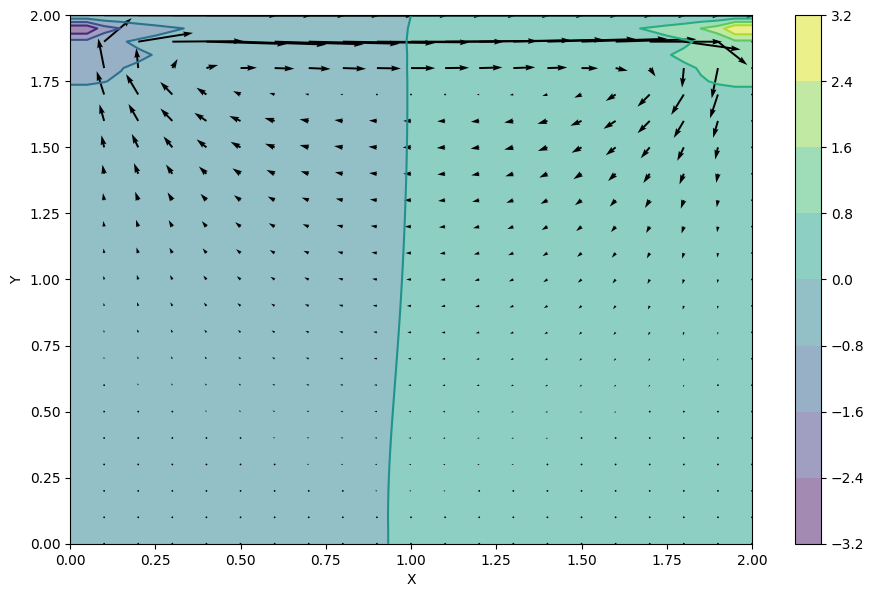

In [454]:
fig = pyplot.figure(figsize=(11,7), dpi=100)
# plotting the pressure field as a contour
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)  
pyplot.colorbar()
# plotting the pressure field outlines
pyplot.contour(X, Y, p, cmap=cm.viridis)  
# plotting velocity field
pyplot.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2]) 
pyplot.xlabel('X')
pyplot.ylabel('Y')

In [455]:
u = numpy.zeros((ny, nx))
v = numpy.zeros((ny, nx))
p = numpy.zeros((ny, nx))
b = numpy.zeros((ny, nx))
nt = 700
u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)

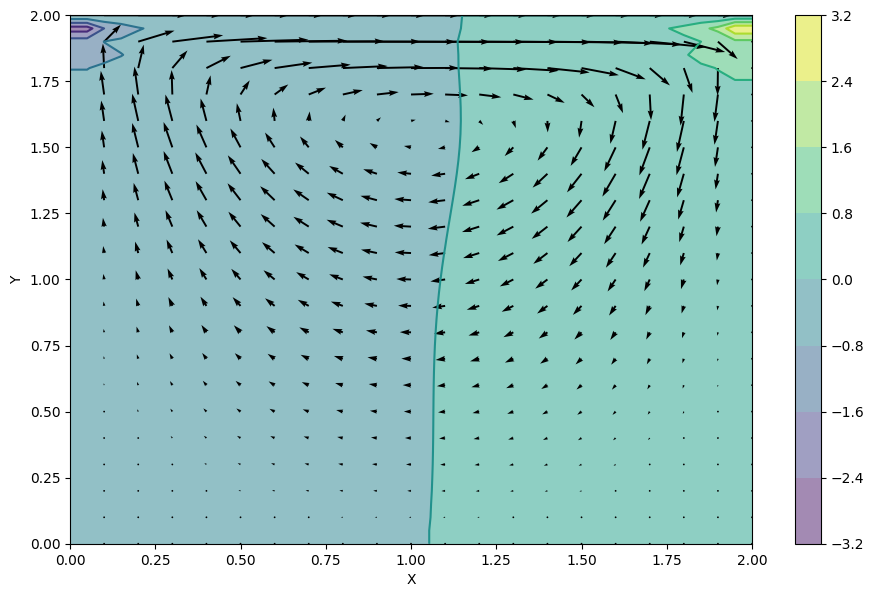

In [456]:
fig = pyplot.figure(figsize=(11, 7), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p, cmap=cm.viridis)
pyplot.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2])
pyplot.xlabel('X')
pyplot.ylabel('Y');

Text(0, 0.5, 'Y')

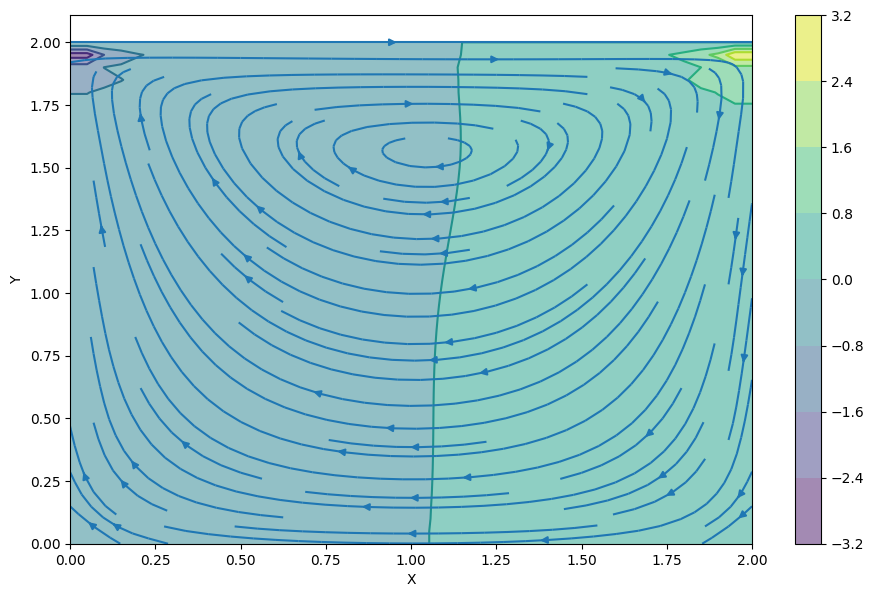

In [457]:
fig = pyplot.figure(figsize=(11, 7), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p, cmap=cm.viridis)
pyplot.streamplot(X, Y, u, v)
pyplot.xlabel('X')
pyplot.ylabel('Y')